In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from adjustText import adjust_text
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', None)

In [2]:
###### ADDED #####
with open('./Leagues/position_stats.json', 'r') as f:
    STATS_PER_POSITION = json.load(f)

In [3]:
# CB = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'Inter',
#         'Offsides',
#         'Clear',
#         'Dribbles allowed',
#         'Blocks',
#         'OwnGoal',
#         'Foul_given_game',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         # 'Average_per_pass',
#         # 'Shortpass_per_game',   
# ]

# RB = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'Inter',
#         'Offsides',
#         'Clear',
#         'Dribbles allowed',
#         'Blocks',
#         'OwnGoal',
#         'Foul_given_game',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',   
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Crosses_per_game',
#         'Longpass_per_game',
#     ]

# LB = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'Inter',
#         'Offsides',
#         'Clear',
#         'Dribbles allowed',
#         'Blocks',
#         'OwnGoal',
#         'Foul_given_game',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Crosses_per_game',
#         'Longpass_per_game',
# ]

# CM = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'SpG',
#         'Key_pass_per_game',
#         'Dribble',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Longpass_per_game',
#         'Through_ball_per_game',
# ]

# CAM = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'SpG',
#         'Key_pass_per_game',
#         'Dribble',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Longpass_per_game',
#         'Through_ball_per_game',
#         'xG',
#         'xGDiff',
#         'xGPerNinety',
#         'totalShots',
#         'xGPerShot',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
# ]

# CDM = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'Inter',
#         'Offsides',
#         'Clear',
#         'Dribbles allowed',
#         'Blocks',
#         'Foul_given_game',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         'Key_pass_per_game',
#         'Dribble',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Longpass_per_game',
#         'Through_ball_per_game',
# ]


# ST = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'SpG',
#         'Dribble',
#         'xG',
#         'xGDiff',
#         'xGPerNinety',
#         'totalShots',
#         'xGPerShot',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#     ]

# LW = [
#         'age',
#         # 'Yel',
#         # 'Red',
#         'SpG',
#         'Dribble',
#         'xG',
#         'xGDiff',
#         'xGPerNinety',
#         'totalShots',
#         'xGPerShot',
#         'Dispossessed_per_game',
#         'Unsuccessful touches',
#         # 'Average_per_pass',
#         'Shortpass_per_game',
#         'Crosses_per_game',
#         'Longpass_per_game',
#     ]

# RW = LW
# LM = LW
# RM = LW


# ## 포지션별 스탯
# STATS_PER_POSITION = {
#     'Goalkeeper' : ['Total_Saves', 'SixYardBox_Saves', 'PenaltyArea_Saves', 'OutOfBox_Saves', 'age'],
#     'Centre-Back' : CB,
#     'Right-Back' : RB,
#     'Left-Back' : LB,
#     'Central Midfield' : CM,
#     'Left Midfield' : LM,
#     'Right Midfield' : RM,
#     'Defensive Midfield' : CDM,
#     'Attacking Midfield' : CAM,
#     'Left Wing' : LW,
#     'Right Wing' : RW,
#     'Centre-Forward' : ST
# }

In [4]:
DATA_DIR = './Leagues'

TARGET = 'Centre-Forward'
N_MOST_SIMILAR_PLAYERS = 50
N_MAX_SIM = 10
N_MID_SIM = 10
N_MIN_SIM = 10

In [5]:
players_stats = pd.read_csv(f'{DATA_DIR}/all_players_stats.csv', encoding='utf-8')
players_values = pd.read_csv(f'{DATA_DIR}/all_players_values.csv', encoding='utf-8')
players_details = pd.read_csv(f'{DATA_DIR}/all_players_stats_details.csv', encoding='utf-8')

teams_stats = pd.read_csv(f'{DATA_DIR}/all_teams_stats.csv', encoding='utf-8')
teams_values = pd.read_csv(f'{DATA_DIR}/all_teams_values.csv', encoding='utf-8')

In [6]:
def convert_market_value(value):
    if pd.isna(value):
        return None
    value = value.replace('€', '').strip().lower()
    if 'm' in value:
        return float(value.replace('m', '')) * 1_000_000
    elif 'k' in value:
        return float(value.replace('k', '')) * 1_000
    try:
        return float(value)
    except ValueError:
        return None

players_values['Market Value'] = players_values['Market Value'].apply(convert_market_value)

In [7]:
players_details_reduced = players_details.drop(columns=['player_name', 'team_name'])
players_totals = players_stats.merge(players_details_reduced, left_index=True, right_index=True, how='left')

players_values_reduced = players_values.drop(columns=['Team', 'Position', 'Date of Birth', 'Age', 'Nationality'])
players_values_reduced.rename(columns={'Name': 'player_name'}, inplace=True)
players_totals = players_totals.merge(players_values_reduced, on='player_name', how='left')

players_totals.rename(columns={
    'Red_x': 'Red', 
    'Fouls_y' : 'Fouls', 
    'Yellow' : 'Yel_x',
    'Yel' : 'Yellow',
    'Short' : 'Shortpass_per_game',
    'Unsuccessful' : 'Unsuccessful_Dribbles',
    'Successful' : 'Successful_Dribbles',
    'Won' : 'AerialWon',
    'Lost' : 'AerialLost',
    'Long' : 'Long_Keypass',
    'Short' : 'Short_Keypass',
    'Cross' : 'Cross_Assist',
    'Corner' : 'Corner_Assist',
    'Throughball' : 'Throughball_Assist',
    'Freekick' : 'Freekick_Assist',
    'Throwin' : 'Throwin_Assist',
    'Other' : 'Other_Assist',
    'Average_per_pass' : 'Passes_per_game'

}, inplace=True)
players_totals = players_totals[[col for col in players_totals.columns if not col.endswith('_x') and not col.endswith('_y')]]

players_totals['team_name'] = players_totals['team_name'].fillna('')
players_totals.drop_duplicates(subset=['player_name', 'team_name'], inplace=True)

players_totals.to_csv('./Leagues/all_players_stats_total.csv', index=False)
players_totals.head(10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2201: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,player_name,team_name,age,position,Apps,Mins,Goals,Assists,Yellow,Red,...,Long_Keypass,Short_Keypass,Cross_Assist,Corner_Assist,Throughball_Assist,Freekick_Assist,Throwin_Assist,Other_Assist,Total_Assists,Market Value
0,Asmir Begovic,Everton,36,Goalkeeper,1,90,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800000.0
1,Kevin De Bruyne,Manchester City,32,Attacking Midfield,28(4),2425,7,16,1,0,...,0.8,2.2,0.2,0.0,0.1,0.0,0.0,0.2,0.5,70000000.0
2,Stefan Ortega,Manchester City,31,Goalkeeper,3,270,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9000000.0
3,Erling Haaland,Manchester City,23,Centre-Forward,33(2),2779,36,8,5,0,...,0.0,0.9,0.0,0.0,0.1,0.0,0.0,0.2,0.2,180000000.0
4,Harry Kane,Tottenham,30,Centre-Forward,38,3408,30,3,6,0,...,0.3,1.2,0.0,0.0,0.0,0.0,0.0,0.1,0.1,90000000.0
5,Bruno Fernandes,Manchester United,29,Attacking Midfield,37,3320,8,8,6,0,...,0.6,2.6,0.0,0.0,0.1,0.0,0.0,0.1,0.2,75000000.0
6,Gabriel Jesus,Arsenal,27,Centre-Forward,24(2),2075,11,6,6,0,...,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.2,0.2,75000000.0
7,Kieran Trippier,Newcastle,33,Right-Back,38,3348,1,7,5,0,...,1.7,1.2,0.1,0.0,0.0,0.1,0.0,0.0,0.2,11000000.0
8,Bukayo Saka,Arsenal,22,Right Winger,37(1),3195,14,11,6,0,...,0.5,1.5,0.1,0.1,0.0,0.0,0.0,0.2,0.3,120000000.0
9,Solly March,Brighton,29,Right Winger,31(2),2728,7,7,2,0,...,0.4,1.6,0.1,0.0,0.0,0.0,0.0,0.1,0.2,22000000.0


In [8]:
def group_top_teams_by_position(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    top_teams = all_teams_stats.nlargest(15, 'Pts')['team_name'].tolist()
    top_teams_df = all_players_stats[
        (all_players_stats['team_name'].isin(top_teams)) &
        (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
    ].copy()
    top_teams_df['positions'] = top_teams_df['position'].apply(lambda x: [pos.strip() for pos in x.split(',') if pd.notna(x)])
    all_positions = set(pos for positions in top_teams_df['positions'] for pos in positions)
    position_groups = {pos: [] for pos in all_positions}
    for _, row in top_teams_df.iterrows():
        player_name = row['player_name']
        player_positions = row['positions']
        for pos in player_positions:
            position_groups[pos].append(player_name)
    return position_groups, top_teams


def group_lower_teams_by_position_per_league(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    excluded_teams_per_league = all_teams_stats.groupby('League').apply(lambda x: x.nlargest(3, 'Pts')['team_name']).tolist()
    position_groups = {}
    for league in all_teams_stats['League'].unique():
        lower_teams = all_teams_stats[
            (all_teams_stats['League'] == league) &
            (~all_teams_stats['team_name'].isin(excluded_teams_per_league))
        ]['team_name'].tolist()
        lower_teams_df = all_players_stats[
            (all_players_stats['team_name'].isin(lower_teams)) &
            (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
        ]
        for _, row in lower_teams_df.iterrows():
            positions = [pos.strip() for pos in row['position'].split(',') if pd.notna(row['position'])]
            player_name = row['player_name']
            for pos in positions:
                if pos in position_groups:
                    position_groups[pos].append(player_name)
                else:
                    position_groups[pos] = [player_name]
    return position_groups

In [9]:
# def find_similar_players(top_players_stats, top_position_groups, bottom_players_stats, bottom_position_groups, position, n=10):
#     top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[position])]
#     bottom_players_stats_filtered = bottom_players_stats[bottom_players_stats['player_name'].isin(bottom_position_groups[position])]
    
#     stat_columns = STATS_PER_POSITION[position]
#     imputer = SimpleImputer(strategy='mean')
#     top_players_stats_imputed = imputer.fit_transform(top_players_stats_filtered[stat_columns])
#     top_players_avg_stats = top_players_stats_imputed.mean(axis=0).reshape(1, -1)
#     bottom_players_stats_imputed = imputer.transform(bottom_players_stats_filtered[stat_columns])
    
#     similarity_scores = cosine_similarity(bottom_players_stats_imputed, top_players_avg_stats)
#     most_similar_indices = similarity_scores.flatten().argsort()[::-1][:n]
#     most_similar_players = bottom_players_stats_filtered.iloc[most_similar_indices]
    
#     return most_similar_players, similarity_scores.flatten()[most_similar_indices]

def find_similar_players(top_players_stats, top_position_groups, bottom_players_stats, bottom_position_groups, position, n=10):
    top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[position])]
    bottom_players_stats_filtered = bottom_players_stats[bottom_players_stats['player_name'].isin(bottom_position_groups[position])]
    
    stat_columns = STATS_PER_POSITION[position]
    
    imputer = SimpleImputer(strategy='mean')
    
    top_players_stats_imputed = imputer.fit_transform(top_players_stats_filtered[stat_columns])
    top_players_median_stats = np.median(top_players_stats_imputed, axis=0).reshape(1, -1)
    
    bottom_players_stats_imputed = imputer.transform(bottom_players_stats_filtered[stat_columns])
    
    similarity_scores = cosine_similarity(bottom_players_stats_imputed, top_players_median_stats)
    most_similar_indices = similarity_scores.flatten().argsort()[::-1][:n]
    most_similar_players = bottom_players_stats_filtered.iloc[most_similar_indices]
    
    return most_similar_players, similarity_scores.flatten()[most_similar_indices]

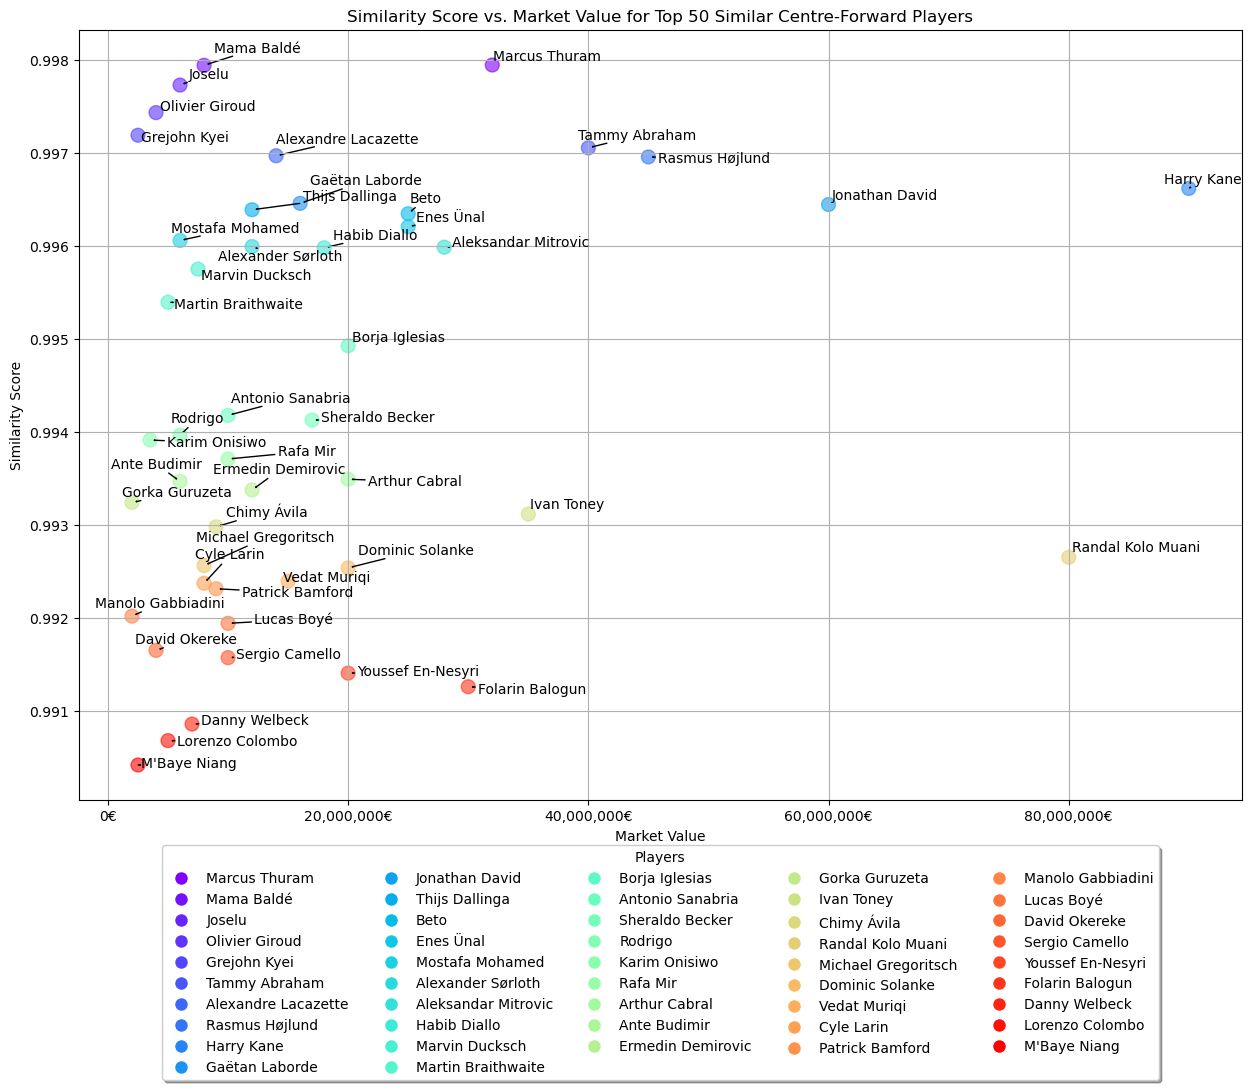

In [10]:
top_position_groups, top_teams = group_top_teams_by_position(players_totals, teams_stats)
bottom_position_groups = group_lower_teams_by_position_per_league(players_totals, teams_stats)

top_players_stats = players_totals[players_totals['team_name'].isin(top_teams)]
bottom_players_stats = players_totals[~players_totals['team_name'].isin(top_teams)]

most_similar_players, similarity_scores = find_similar_players(top_players_stats, top_position_groups, bottom_players_stats, bottom_position_groups, TARGET, N_MOST_SIMILAR_PLAYERS)

top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[TARGET])]
similar_players_stats = bottom_players_stats[bottom_players_stats['player_name'].isin(most_similar_players['player_name'])]

plot_data = most_similar_players[['player_name', 'Market Value']].copy()
plot_data['Similarity Score'] = similarity_scores
plot_data.dropna(subset=['Market Value', 'Similarity Score'], inplace=True)

unique_players = plot_data['player_name'].unique()
color_map = plt.cm.get_cmap('rainbow', len(unique_players))
player_colors = {player: color_map(i) for i, player in enumerate(unique_players)}

plt.figure(figsize=(15, 10))
scatter = plt.scatter(x=plot_data['Market Value'], y=plot_data['Similarity Score'], s=100, c=[player_colors[name] for name in plot_data['player_name']], alpha=0.6)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in player_colors.values()]
plt.legend(handles, player_colors.keys(), title='Players', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

texts = []
for i, row in plot_data.iterrows():
    texts.append(plt.text(row['Market Value'], row['Similarity Score'], row['player_name']))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}€'.format(x)))

plt.xlabel('Market Value')
plt.ylabel('Similarity Score')
plt.title(f'Similarity Score vs. Market Value for Top {N_MOST_SIMILAR_PLAYERS} Similar {TARGET} Players')
plt.grid(True)
plt.show()

In [11]:
similar_players_stats.head()

,player_name,team_name,age,position,Apps,Mins,Goals,Assists,Yellow,Red,...,Long_Keypass,Short_Keypass,Cross_Assist,Corner_Assist,Throughball_Assist,Freekick_Assist,Throwin_Assist,Other_Assist,Total_Assists,Market Value
4,Harry Kane,Tottenham,30,Centre-Forward,38,3408,30,3,6,0,...,0.3,1.2,0.0,0.0,0.0,0.0,0.0,0.1,0.1,90000000.0
14,Ivan Toney,Brentford,28,Centre-Forward,33,2955,20,4,9,0,...,0.1,0.8,0.0,0.0,0.0,0.0,0.0,0.1,0.1,35000000.0
28,Aleksandar Mitrovic,Fulham,29,Centre-Forward,23(1),2015,14,1,7,0,...,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.1,0.1,28000000.0
154,Dominic Solanke,Bournemouth,26,Centre-Forward,32(1),2873,6,7,2,0,...,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000000.0
166,Danny Welbeck,Brighton,33,Centre-Forward,21(10),1859,6,3,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000000.0


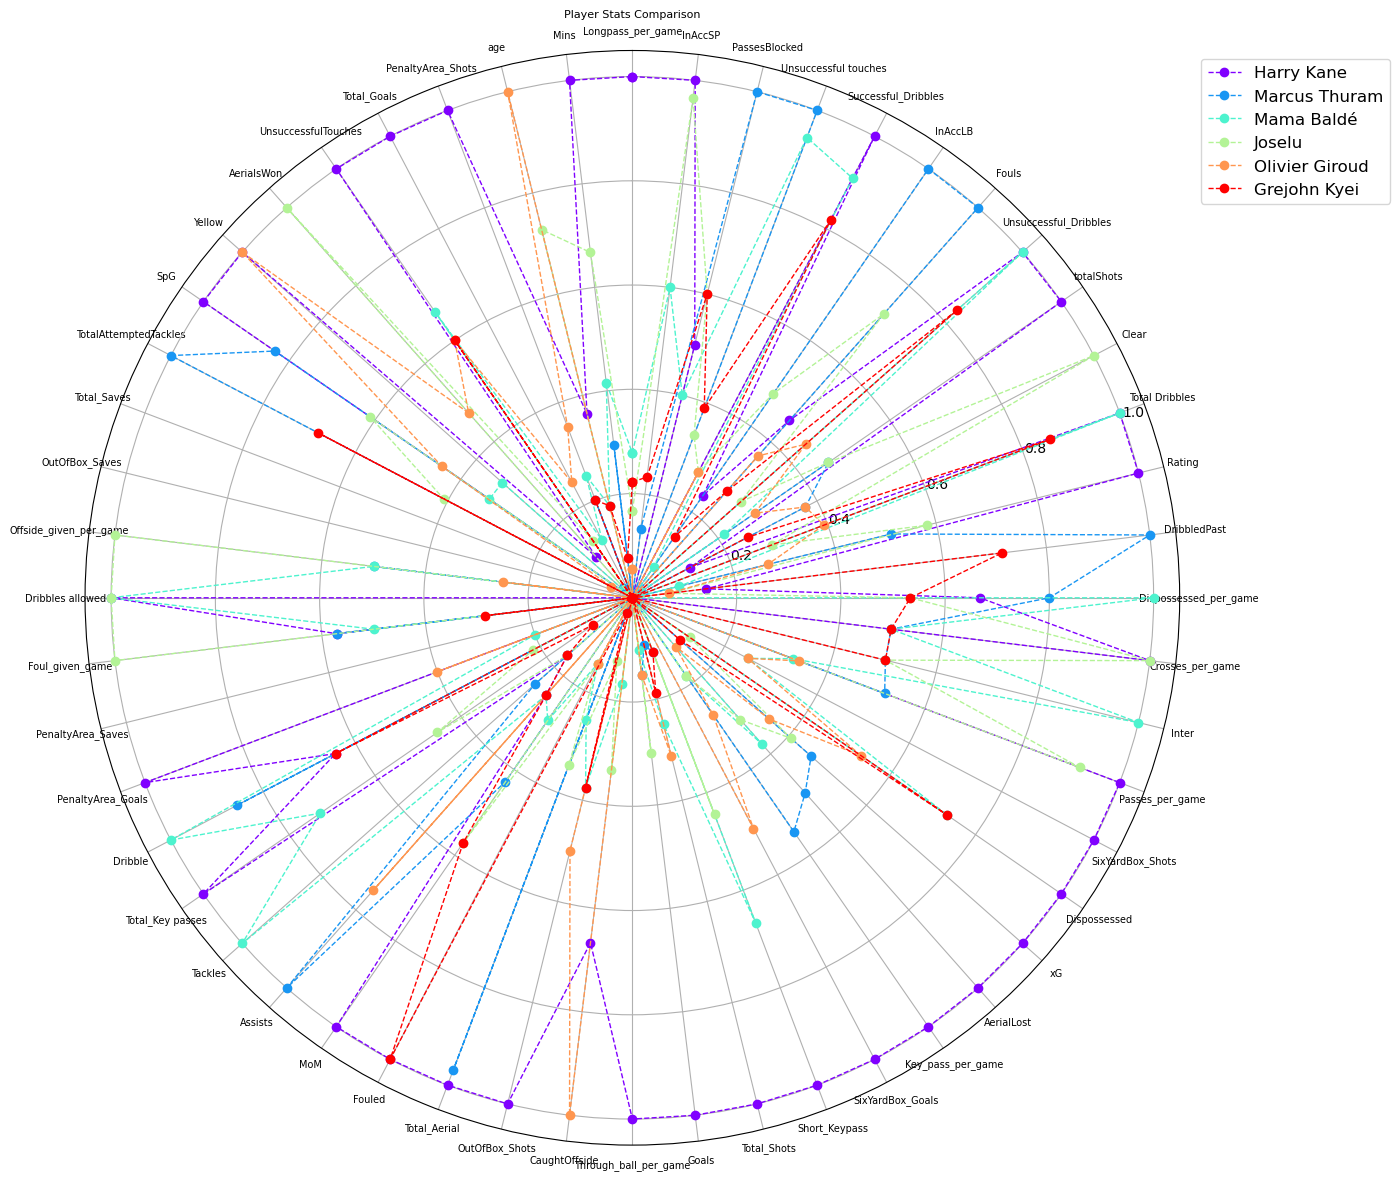

In [27]:
# 시장 가치가 가장 높은 선수 찾기
top_market_value_player = similar_players_stats.loc[similar_players_stats['Market Value'].idxmax()]

# 시장 가치가 낮지만 유사도가 높은 상위 10명의 선수 찾기
# similar_players_stats_sorted = similar_players_stats.sort_values('Market Value')
merged_data = pd.merge(similar_players_stats, plot_data[['player_name', 'Similarity Score']], on='player_name', how='left')
sorted_data = merged_data.sort_values('Similarity Score', ascending=False)
top_10_similar_players = sorted_data.head(5)

# 선택된 선수들의 스탯을 저장할 데이터프레임 생성
selected_players_stats = pd.concat([top_market_value_player.to_frame().T, top_10_similar_players], ignore_index=True)

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-10)

# 그래프 그리기
stat_columns = STATS_PER_POSITION[TARGET] + ['age', 'Mins']
selected_players_stats_normalized = selected_players_stats[stat_columns].apply(normalize)

# stat_columns에 맞는 각도 생성
angles = np.linspace(0, 2 * np.pi, len(stat_columns), endpoint=False).tolist()
angles += angles[:1]

# 레이더 차트 그리기
fig, ax = plt.subplots(figsize=(14, 14), subplot_kw=dict(polar=True))
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_players_stats)))

for i, player in enumerate(selected_players_stats['player_name']):
    player_stats = selected_players_stats_normalized.iloc[i].values.flatten().tolist()
    player_stats += player_stats[:1]
    ax.plot(angles, player_stats, linewidth=1, linestyle='--', marker='o', color=colors[i], label=player)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(70)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=stat_columns, fontsize=7)
ax.set_title("Player Stats Comparison", fontsize=8)
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# stat_columns = STATS_PER_POSITION[TARGET] 

# top_players = similar_players_stats.nlargest(N_MAX_SIM, 'Market Value')
# mid_players = similar_players_stats.iloc[len(similar_players_stats)//2-N_MID_SIM//2:len(similar_players_stats)//2+N_MID_SIM//2+1]
# bottom_players = similar_players_stats.nsmallest(N_MIN_SIM, 'Market Value')

# top_players_avg = top_players[stat_columns].mean()
# mid_players_avg = mid_players[stat_columns].mean()
# bottom_players_avg = bottom_players[stat_columns].mean()

# stat_diff_top_bottom = top_players_avg - bottom_players_avg
# stat_diff_top_mid = top_players_avg - mid_players_avg
# stat_diff_mid_bottom = mid_players_avg - bottom_players_avg

# stat_diff_df = pd.DataFrame({
#     'Stat': stat_columns,
#     'Top vs Bottom': stat_diff_top_bottom,
#     'Top vs Middle': stat_diff_top_mid,
#     'Middle vs Bottom': stat_diff_mid_bottom
# })

# sns.set(style='whitegrid')

# plt.figure(figsize=(10, 10))
# sns.barplot(x='Top vs Bottom', y='Stat', data=stat_diff_df)
# plt.title('Stat Difference: Top N vs Bottom N')
# plt.xlabel('Difference')
# plt.ylabel('Stat')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 10))
# sns.barplot(x='Top vs Middle', y='Stat', data=stat_diff_df)
# plt.title('Stat Difference: Top N vs Middle N')
# plt.xlabel('Difference')
# plt.ylabel('Stat')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 10))
# sns.barplot(x='Middle vs Bottom', y='Stat', data=stat_diff_df)
# plt.title('Stat Difference: Middle N vs Bottom N')
# plt.xlabel('Difference')
# plt.ylabel('Stat')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [ ]:
# stat_columns = STATS_PER_POSITION[TARGET] 

# ## Top Players Average 계산
# top_players_avg_stats = top_players_stats_filtered[stat_columns].mean()
# top_players_avg_stats = pd.DataFrame(top_players_avg_stats).T
# top_players_avg_stats.columns = stat_columns
# top_players_avg_stats['player_name'] = 'Top Players Average'

# full_columns = similar_players_stats.columns
# top_players_avg_stats_full = pd.DataFrame(columns=full_columns)

# for col in top_players_avg_stats.columns:
#     if col in top_players_avg_stats_full.columns:
#         top_players_avg_stats_full[col] = top_players_avg_stats[col].values

# for col in top_players_avg_stats_full.columns:
#     if col not in top_players_avg_stats.columns:
#         top_players_avg_stats_full[col] = 0 if similar_players_stats[col].dtype.kind in 'biufc' else 'Unknown'

# top_players_avg_stats_full = top_players_avg_stats_full.reset_index(drop=True)
# combined_stats = pd.concat([similar_players_stats, top_players_avg_stats_full], ignore_index=True)

# for col in stat_columns:
#     if col in combined_stats.columns:
#         plt.figure(figsize=(12, 10))
#         sns.barplot(data=combined_stats, x=col, y='player_name', errorbar=None)
#         plt.title(f'{col}')
#         plt.xlabel(col)
#         plt.ylabel('Player Name')
#         plt.show()

In [ ]:
# stat_columns = STATS_PER_POSITION[TARGET]

# top_players_avg_stats = top_players_stats_filtered[stat_columns].mean()
# top_players_avg_stats = pd.DataFrame(top_players_avg_stats).T
# top_players_avg_stats.columns = stat_columns
# top_players_avg_stats['player_name'] = 'Top Players Average'
# top_players_avg_stats['age'] = combined_stats['age'].mean()
# top_players_avg_stats['Market Value'] = combined_stats['Market Value'].mean()

# full_columns = similar_players_stats.columns
# top_players_avg_stats_full = pd.DataFrame(columns=full_columns)
# for col in top_players_avg_stats.columns:
#     if col in top_players_avg_stats_full.columns:
#         top_players_avg_stats_full[col] = top_players_avg_stats[col].values

# for col in top_players_avg_stats_full.columns:
#     if col not in top_players_avg_stats.columns:
#         top_players_avg_stats_full[col] = 0 if similar_players_stats[col].dtype.kind in 'biufc' else 'Unknown'

# top_players_avg_stats_full = top_players_avg_stats_full.reset_index(drop=True)
# combined_stats = pd.concat([similar_players_stats, top_players_avg_stats_full], ignore_index=True)
# colors = np.random.rand(len(combined_stats), 3)
# for col in stat_columns:
#     if col in combined_stats.columns:
#         fig = plt.figure(figsize=(12, 10))
#         ax = fig.add_subplot(111, projection='3d')
        
#         for i, player in enumerate(combined_stats['player_name']):
#             ax.scatter(
#                 combined_stats['Market Value'][i],
#                 combined_stats['age'][i],
#                 combined_stats[col][i],
#                 color=colors[i],
#                 label=player
#             )
        
#         ax.set_title(f'{col}')
        
#         x_ticks = ax.get_xticks()
#         x_labels = ['€{:,.0f}'.format(x) for x in x_ticks]
#         ax.set_xticklabels(x_labels)
#         ax.set_xlabel('Market Value')
        
#         ax.set_ylabel('Age')
#         ax.set_zlabel(col)
        
#         plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5, fontsize='small')
#         plt.subplots_adjust(bottom=0.2)
        
#         plt.show()